Using TensorFlow backend.


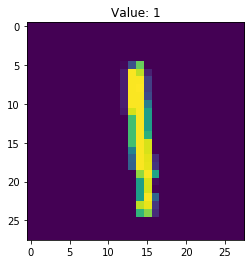

178
Train matrix shape (60000, 28, 28, 1)
Test matrix shape (10000, 28, 28, 1)
Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)


In [1]:
# based on steps in https://www.tensorflow.org/lite/performance/post_training_integer_quant
# adding Keras layer by https://github.com/keras-team/keras/issues/2221

import tensorflow as tf
import numpy as np
import h5py
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import math

from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Sequential
import tensorflow.python.keras
# import tensorflow.contrib.keras as keras
from keras.utils import to_categorical

import os

(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()

i = 8
plt.title('Value: ' + str(y_train[i]))
plt.imshow(x_train[i])
plt.show()
print(x_train[i][13][13])
img_rows, img_cols = 28, 28
    
#Siapkan matrix training 
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
# print the final input shape ready for training
print("Train matrix shape", x_train.shape)
print("Test matrix shape", x_test.shape)
# one-hot encoding using keras' numpy-related utilities
# one hot encoding = index neuron dengan nilai paling tinggi menjadi hasil klasifikasi
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", y_train.shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Conv2D)             (None, 26, 26, 16)        144       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
layer_2 (Conv2D)             (None, 11, 11, 16)        2304      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
layer_3 (Dense)              (None, 10)                4000      
_________________________________________________________________
layer_Output (Dense)         (None, 10)                1

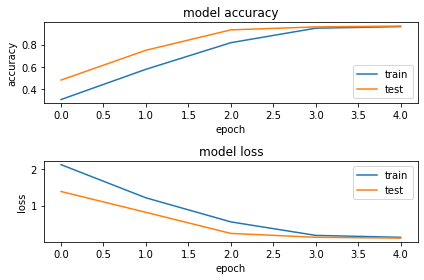

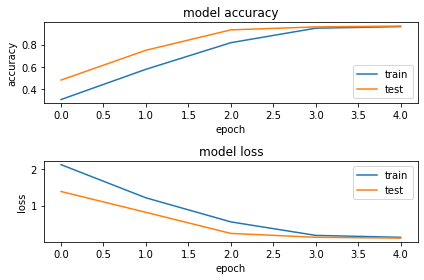

In [2]:
# import keras.backend as K
# decimalpoint = 8
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), use_bias=False, activation=tf.nn.relu,input_shape=(28,28,1), name='layer_1'),
    # tf.keras.layers.Lambda(lambda x: K.round(x * (2 ** decimalpoint)) / (2 ** decimalpoint)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(16, (3,3), use_bias=False, activation=tf.nn.relu, name='layer_2'),
    # tf.keras.layers.Lambda(lambda x: K.round(x * (2 ** decimalpoint)) / (2 ** decimalpoint)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, use_bias=False, activation=tf.nn.relu, name='layer_3'),
    # tf.keras.layers.Lambda(lambda x: K.round(x * (2 ** decimalpoint)) / (2 ** decimalpoint)),
    tf.keras.layers.Dense(10, use_bias=False, activation=tf.nn.softmax, name='layer_Output'),
    # tf.keras.layers.Lambda(lambda x: K.round(x * (2 ** decimalpoint)) / (2 ** decimalpoint)),
])

# compile the models
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

# training the model and saving metrics in history
history = model.fit(x_train, y_train,
          batch_size=128, epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rounded_layer_1 (Conv2D)     (None, 26, 26, 16)        144       
_________________________________________________________________
round (Round)                (None, 26, 26, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
rounded_layer_2 (Conv2D)     (None, 11, 11, 16)        2304      
_________________________________________________________________
round_1 (Round)              (None, 11, 11, 16)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)              

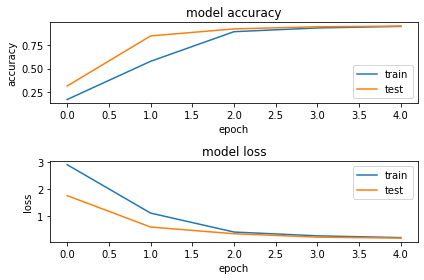

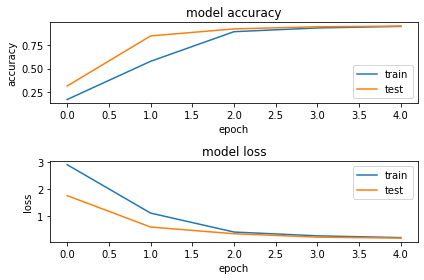

In [3]:
from tensorflow.python.keras.layers import Layer
import keras.backend as K

class Round(Layer):

    def __init__(self, **kwargs):
        super(Round, self).__init__(**kwargs)

    def get_output(self, train=False):
        X = self.get_input(train)
        return K.round(X * 4096) / 4096.0

    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(Round, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
model_rounded = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), use_bias=False, activation=tf.nn.relu,input_shape=(28,28,1), name='rounded_layer_1'),
    Round(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(16, (3,3), use_bias=False, activation=tf.nn.relu, name='rounded_layer_2'),
    Round(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, use_bias=False, activation=tf.nn.relu, name='rounded_layer_3'),
    Round(),
    tf.keras.layers.Dense(10, use_bias=False, activation=tf.nn.softmax, name='rounded_layer_Output'),
    Round(),
])

# compile the models
model_rounded.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model_rounded.summary())
# training the model and saving metrics in history
history_rounded = model_rounded.fit(x_train, y_train,
          batch_size=128, epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history_rounded.history['accuracy'])
plt.plot(history_rounded.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history_rounded.history['loss'])
plt.plot(history_rounded.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
integered_layer_1 (Conv2D)   (None, 26, 26, 16)        144       
_________________________________________________________________
integer (Integer)            (None, 26, 26, 16)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
integered_layer_2 (Conv2D)   (None, 11, 11, 16)        2304      
_________________________________________________________________
integer_1 (Integer)          (None, 11, 11, 16)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)              

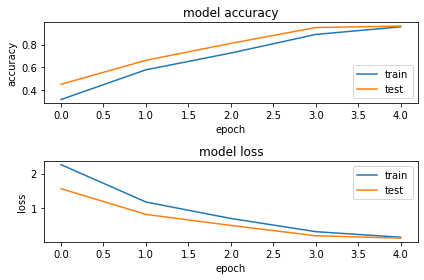

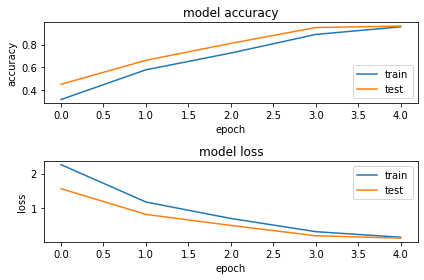

In [4]:
class Integer(Layer):

    def __init__(self, **kwargs):
        super(Integer, self).__init__(**kwargs)

    def get_output(self, train=False):
        X = self.get_input(train)
        return X / 4096.0

    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(Integer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
model_integered = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), use_bias=False, activation=tf.nn.relu,input_shape=(28,28,1), name='integered_layer_1'),
    Integer(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(16, (3,3), use_bias=False, activation=tf.nn.relu, name='integered_layer_2'),
    Integer(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, use_bias=False, activation=tf.nn.relu, name='integered_layer_3'),
    Integer(),
    tf.keras.layers.Dense(10, use_bias=False, activation=tf.nn.softmax, name='integered_layer_Output')
])

# compile the models
model_integered.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model_integered.summary())
# training the model and saving metrics in history
history_integered = model_integered.fit(x_train, y_train,
          batch_size=128, epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history_integered.history['accuracy'])
plt.plot(history_integered.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history_integered.history['loss'])
plt.plot(history_integered.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig